In [1]:
#imports
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet18,ResNet18_Weights
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import multiprocessing as mp
import string
import cv2

In [2]:
#cpu counts for multiprocessing
cpu_count = mp.cpu_count()

In [3]:
#path where images are stored
data_path = "./kaggle/input/captcha-version-2-images/samples"

In [4]:
#get name of images and put them in a list
image_fns = os.listdir(data_path)
np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns])

array([5])

In [5]:
#check if any image name is not equal to 5
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split('.')[0])!=5:
        print(idx,image_fn)

In [6]:
#split data into test and train data
x_train,x_test = train_test_split(image_fns,random_state=42)
len(x_train),len(x_test)

(802, 268)

In [7]:
#create a list of all the unique letters and numbers for encoding
image_ns = [image_fn.split('.')[0] for image_fn in image_fns]
image_ns = ''.join(image_ns)
unique_let = sorted(list(set(list(image_ns))))
len(unique_let)
#unique_let

19

In [8]:
#make dictionary of unique symbols as well as a reverse dictionary
#for encoding and decoding purposes
#'-' added to vocab because CTCLoss adds a '-' to the loss output to 
#seperate loss of different time sequences
vocabulary = ['-' ]+ unique_let
print(len(vocabulary))
print(vocabulary)
idx2char = {a:b for a,b in enumerate(vocabulary,start=0)}
print(idx2char)
char2idx = {b:a for a,b in idx2char.items()}
print(char2idx)

20
['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}


In [9]:

class CaptchaDataset(Dataset):
    #initialize dataset
    def __init__(self,data_dir,image_fns):
        self.data_dir = data_dir
        self.image_fns = image_fns
        #return length of dataset
    def __len__(self):
        return len(self.image_fns)
        #return each transformed image and corresponding label from the dataset
    def __getitem__(self,index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir,image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split('.')[0]
        return image,text
        #tranform image acording to ImageNet mean and std standards
    def transform(self,image):
        transform_ops = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize(mean=(0.485,0.456,0.406),
            std=(0.229,0.224,0.225))])
        return transform_ops(image)
        

In [10]:
#create trainset,testset and from them create train,test dataloaders
trainset = CaptchaDataset(data_path,x_train)
testset = CaptchaDataset(data_path,x_test)
train_loader = DataLoader(trainset,batch_size=16,num_workers=0,shuffle=True)
test_loader = DataLoader(testset,batch_size=16,num_workers=0,shuffle=False)
len(train_loader),len(test_loader)

(51, 17)

In [11]:
#check batch for any discrepencies
image_batch, text_batch = next(iter(train_loader))
image_batch.size(),text_batch

(torch.Size([16, 3, 50, 200]),
 ('226md',
  '445cc',
  'm3588',
  '387g2',
  'pgwnp',
  'y7mnm',
  '87d4c',
  'fp762',
  'w48cw',
  '6e2dg',
  'dbny3',
  'nm248',
  'bpwd7',
  '6c3n6',
  '7f8b3',
  '77n6g'))

In [12]:
#check dictionary length
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

20


In [13]:
#check gpu processing availability
torch.cuda.is_available()

True

In [14]:
# device variable to do processing on gpu if we please
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

In [16]:
#CRNN architectue
class CRNN(nn.Module):
    # initializing key parameters
    def __init__(self,num_chars,rnn_hidden_size=256,dropout=0.1):
        super(CRNN,self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size=rnn_hidden_size
        self.dropout = dropout

        #CRNN Part 1
        #unpack all of pretrained resnet model except the last 3 layers
        resnet_modules = list(resnet18.children())[:-3]
        # .Sequential ensures sequential execution of layers
        self.cnn_p1 = nn.Sequential(*resnet_modules)

        #CRNN Part 2
        #Sequential layer of order Convolution, Batch Normalization, and ReLU
        self.cnn_p2 = nn.Sequential(nn.Conv2d(256,256,kernel_size=(3,6),stride=1,padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(inplace=True))
        #Linear layer to map activations of last layer to 256 as preperation for next layer
        self.linear1 = nn.Linear(1024,256)

        #RNN
        #GRU layer with bidirectionality so 512 outputs
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size,
                           hidden_size=rnn_hidden_size,
                           bidirectional=True,
                           batch_first=True)
        #Another GRU layer with bidirectionality however it takes 256 input activations
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size,
                           hidden_size=rnn_hidden_size,
                           bidirectional=True,
                           batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2,num_chars)
        
    #forward pass
    def forward(self,batch):
        # pass through cnn part 1
        batch = self.cnn_p1(batch) #[-1,256,4,13]
        #pass through cnn part 2
        batch = self.cnn_p2(batch) #[-1,256,4,10]
        #change order of dimensions as preperation for next layer
        batch = batch.permute(0,3,1,2) #[-1,10,256,4]
        #change order of dimensions as preperation for next layer
        batch_size = batch.size(0)
        T = batch.size(1)
        #changed order and collapsed remaining layers into 1
        batch = batch.view(batch_size,T,-1) #[-1,10,1024]
        #pass through linear layer
        batch = self.linear1(batch) #[-1,10,256]
        #pass through 1st GRU layer
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        #half the last dimensions attributes to load into next layer
        batch = batch[:,:,:feature_size//2] + batch[:,:,feature_size//2:] #[-1,10,256]
        # pass through 2nd GRU layer
        batch, hidden = self.rnn2(batch) #[-1,10,512]
        #pass through linear layer to map output of last layer to the length of the vocab
        batch = self.linear2(batch) #[-1,10,20]
        #rearrange shape of tensor for further processing
        batch = batch.permute(1,0,2) #[10,-1,20]
        #return processed batch
        return batch

        
                                    

In [17]:
#initialize weights for new layers (non-pretrained)
def weights_init(m):
    #extract name of layers in architecture
    classname = m.__class__.__name__
    # check if name is in list
    if type(m) in [nn.Linear,nn.Conv2d, nn.Conv1d]:
        #initialize weights
        torch.nn.init.xavier_uniform_(m.weight)
        #if bias exists set bias for each layer
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    #check if layer is BatchNorm
    elif classname.find('BatchNorm') != -1:
        #initialize weights and bias for this layer
        m.weight.data.normal_(1.0,0.02)
        m.bias.data.fill_(0)

In [18]:
#make an object of class CRNN and initialize weights and set gpu for processing
crnn = CRNN(num_chars,rnn_hidden_size=256)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [19]:
#pass batch into the CRNN object and check output for any discrepencies
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('226md', '445cc', 'm3588', '387g2', 'pgwnp', 'y7mnm', '87d4c', 'fp762', 'w48cw', '6e2dg', 'dbny3', 'nm248', 'bpwd7', '6c3n6', '7f8b3', '77n6g')
torch.Size([10, 16, 20])


In [20]:
#set loss criterion (CTC for models with varying input and outputs)
criterion = nn.CTCLoss(blank=0)

In [21]:
#encode text using dictionary for easy processing
def encode_text_batch(text_batch):

    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)

    text_batch_concat = ''.join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)

    return text_batch_targets,text_batch_targets_lens

In [22]:
# function for computing loss
def compute_loss(text_batch,text_batch_logits):
    text_batch_logps = F.log_softmax(text_batch_logits,2) #[10,-1,20]
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),),
                                        fill_value=text_batch_logps.size(0),
                                        dtype=torch.int32).to(device) #[batch_size]

    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)

    loss = criterion(text_batch_logps,text_batch_targets,text_batch_logps_lens,text_batch_targets_lens)
    return loss

In [23]:
#hyperparameters
num_epochs = 100
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [24]:
#initialize optimizer and learning rate scheduler
optimizer = optim.Adam(crnn.parameters(),lr=lr,weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True,patience=5)

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [25]:
#make an object of class CRNN and initialize weights and set gpu for processing
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [26]:
#train the model
epoch_losses = []
iteration_losses= []
num_updates_epochs=[]
for epoch in tqdm(range(1,num_epochs+1)):
    epoch_loss_list=[]
    num_updates_epoch = 0
    for image_batch,text_batch in tqdm(train_loader,leave=False):
        #reset optimizer grad on each epoch
        optimizer.zero_grad()
        #forward pass
        text_batch_logits = crnn(image_batch.to(device))
        #compute loss
        loss = compute_loss(text_batch,text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue

        num_updates_epoch +=1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        #backwards pass
        loss.backward()
        #clip gradients to prevent from them from blowing up
        nn.utils.clip_grad_norm_(crnn.parameters(),clip_norm)
        #optimizer step
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    #update on key metrics
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    #lr_schedular step
    lr_scheduler.step(epoch_loss)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:1    Loss:2.984392105364332    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:2    Loss:2.3672737093532787    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:3    Loss:1.862944944232118    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:4    Loss:1.5262042120391248    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:5    Loss:1.341753646439197    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:6    Loss:1.2406346190209483    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:7    Loss:1.1536321359522201    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:8    Loss:1.0807141135720646    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:9    Loss:1.04936679204305    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:10    Loss:1.0191463173604478    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:11    Loss:0.9865954752061882    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:12    Loss:0.9706762935601029    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:13    Loss:0.9427797782654855    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:14    Loss:0.9300631331462487    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:15    Loss:0.9336810930102479    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:16    Loss:0.9353868879523932    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:17    Loss:0.8977523025344399    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:18    Loss:0.8302953056260651    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:19    Loss:0.7890360296941271    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:20    Loss:0.8044860573375926    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:21    Loss:0.8880785937402763    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:22    Loss:0.7950546612926558    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:23    Loss:0.7439847904093125    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:24    Loss:0.7558990050764645    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:25    Loss:0.7282232268183839    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:26    Loss:0.6925102472305298    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:27    Loss:0.6906896420553619    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:28    Loss:0.6822718428630455    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:29    Loss:0.6896631402127883    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:30    Loss:0.7532949751498652    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:31    Loss:0.731375562209709    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:32    Loss:0.6827894823223937    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:33    Loss:0.6524311187220555    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:34    Loss:0.6438310029459935    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:35    Loss:0.6751197646645939    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:36    Loss:0.7844292661722969    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:37    Loss:0.7641150168344086    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:38    Loss:0.6660197634322971    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:39    Loss:0.6265906411058763    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:40    Loss:0.613878091176351    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:41    Loss:0.609981446873908    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:42    Loss:0.6221888638010212    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:43    Loss:0.6160614034708809    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:44    Loss:0.6289049001301036    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:45    Loss:0.7109817465146383    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:46    Loss:0.7132525163538316    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:47    Loss:0.6926412114910051    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:48    Loss:0.59312756505667    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:49    Loss:0.5621241132418314    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:50    Loss:0.552619575285444    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:51    Loss:0.5453633782910365    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:52    Loss:0.5413103734745699    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:53    Loss:0.5350342246831632    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:54    Loss:0.5304190551533419    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:55    Loss:0.52770089635662    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:56    Loss:0.525419137057136    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:57    Loss:0.52248935138478    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:58    Loss:0.521086228244445    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:59    Loss:0.5190296681488261    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:60    Loss:0.5151291361042097    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:61    Loss:0.5116719913248923    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:62    Loss:0.5115203500962725    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:63    Loss:0.5092415377205494    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:64    Loss:0.5054998567291334    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:65    Loss:0.5042284294670704    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:66    Loss:0.5033801548621234    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:67    Loss:0.5020633141199747    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:68    Loss:0.5041243398890776    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:69    Loss:0.4991341040414922    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:70    Loss:0.49787689540900437    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:71    Loss:0.4958985488788754    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:72    Loss:0.4955733459369809    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:73    Loss:0.49463851662243113    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:74    Loss:0.4925476704158035    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:75    Loss:0.4909915731233709    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:76    Loss:0.48934526887594487    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:77    Loss:0.4888007313597436    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:78    Loss:0.4881328034634684    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:79    Loss:0.48526111303591263    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:80    Loss:0.4842976916070078    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:81    Loss:0.4831380721400766    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:82    Loss:0.4825197078433691    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:83    Loss:0.4796905488360162    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:84    Loss:0.4799507067484014    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:85    Loss:0.4802694834914862    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:86    Loss:0.4804549439280641    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:87    Loss:0.4815164956392026    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:88    Loss:0.4780098018692989    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:89    Loss:0.47700445383202794    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:90    Loss:0.47764242922558503    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:91    Loss:0.47648314868702607    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:92    Loss:0.47603052620794256    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:93    Loss:0.4738638500372569    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:94    Loss:0.4743675735651278    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:95    Loss:0.4741840824192646    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:96    Loss:0.47138091045267444    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:97    Loss:0.47208035810320986    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:98    Loss:0.47328800255177067    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:99    Loss:0.47365719255279093    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:100    Loss:0.4737685316917943    NumUpdates:51


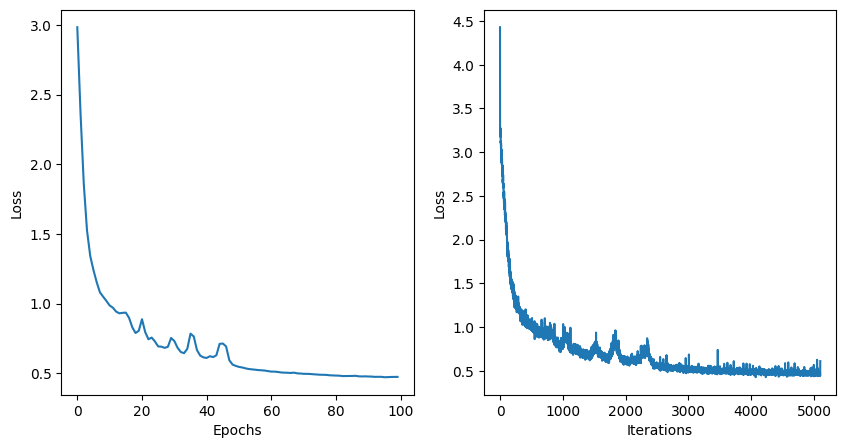

In [27]:
#plot key metrics
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(epoch_losses)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(iteration_losses)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')

plt.show()

In [28]:
#text decoder after processing
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [29]:
#store actual labels and predictions in a dataframe
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=0, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

  0%|          | 0/51 [00:00<?, ?it/s]

In [30]:
#do the same for the test set
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=0, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [31]:
print(results_train.shape)
results_train.head()

(802, 2)


,actual,prediction
0,x3fwf,xx33ffwwff
1,gcfgp,ggccffggpp
2,7y2x4,77yy22xx44
3,6n6gg,66nn66g--g
4,x4pnp,xx44ppnnpp


In [32]:
print(results_test.shape)
results_test.head()

(268, 2)


,actual,prediction
0,fxpw3,ffxxppww33
1,ffnxn,ff-fnnxxnn
2,3b4we,33bb44wwee
3,x277e,xx227-77ee
4,n6nn2,nn66n--n22


In [33]:
#remove duplicate symbols
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [34]:
#apply correction on predicted labels
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,x3fwf,xx33ffwwff,x3fwf
1,gcfgp,ggccffggpp,gcfgp
2,7y2x4,77yy22xx44,7y2x4
3,6n6gg,66nn66g--g,6n6gg
4,x4pnp,xx44ppnnpp,x4pnp


In [35]:
#do the same for test set
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,fxpw3,ffxxppww33,fxpw3
1,ffnxn,ff-fnnxxnn,ffnxn
2,3b4we,33bb44wwee,3b4we
3,x277e,xx227-77ee,x277e
4,n6nn2,nn66n--n22,n6nn2


In [36]:
#check mistakes to see if further processing can be done to fix issues
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
19,77387,7--7888877,7787
21,cen55,cceenn5555,cen5
22,33b22,3333bb2222,3b2
23,c7nn8,cc77nnnn88,c7n8
26,y33nm,yy3333nnmm,y3nm
31,d22n7,dd2222nn77,d2n7
36,g888x,gg8----8xx,g88x
52,xyyyw,xxyy--yyww,xyyw
57,bw44w,bbww4444ww,bw4w
73,x44n4,xx4444n444,x4n4


In [37]:
#check length of corrected preds
print(mistakes_df['prediction_corrected'].str.len().value_counts())

prediction_corrected
4    20
3     5
Name: count, dtype: int64


In [38]:
mask = mistakes_df['prediction_corrected'].str.len() == 4
mistakes_df[mask]

,actual,prediction,prediction_corrected
19,77387,7--7888877,7787
21,cen55,cceenn5555,cen5
23,c7nn8,cc77nnnn88,c7n8
26,y33nm,yy3333nnmm,y3nm
31,d22n7,dd2222nn77,d2n7
36,g888x,gg8----8xx,g88x
52,xyyyw,xxyy--yyww,xyyw
57,bw44w,bbww4444ww,bw4w
73,x44n4,xx4444n444,x4n4
90,yw667,yyww666677,yw67


./kaggle/input/captcha-version-2-images/samples\77387.png


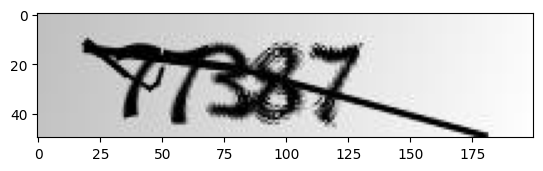

In [39]:
#print image to see if image is the reason for error
mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".png")
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

In [40]:
#test accuracy and train accuracy
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.9875311720698254
0.9067164179104478
